## Import needed Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imageio import imread

## Read given images

In [2]:
car = imread('car.jpg')
flower = imread('flower.png')
palm_leaf_1 = imread('palmleaf1.jpg')
palm_leaf_2 = imread('palmleaf2.jpg')

## Otsu Thresholding

Otsu Thresholding aims to get a global threshold that can then be used to binarize the image. The optimal threshold would essentially minimise the intra-class variances and maximise the inter-class variance. Given an image with $N$ pixels, $N_1$ pixels in the first class and $N_2$ pixels in the second, the inter-class and intra-class and image variances can be given as
$\sigma_T^2(t) = \sigma_w^2(t) + \sigma_b^2(t)$. $\sigma_T^2$ is a constant. Upon maximising $\sigma_b$, we get the optimal threshold.

We have $\sigma_b^2 = \Sigma_{j=1}^{2}(u_j - u_T)^2(N_i/N)$, for every t, and $u_j$ is the corresponding class means. The 't' with maximum $\sigma_b^2$ thus gives the optimal threshold.


In [3]:
def get_Otsu_threshold (image):
    image = image.astype(np.float64)
    N = np.size(image)
    #get all unique pixel values
    thresholds = np.unique(image)
    n_t_vals = len(thresholds)
    #bw_class_var = np.zeros((n_t_vals))
    #if the image contains only one pixel then the image is already 
    #binarized
    if n_t_vals == 1:
        return 0
    #if the image has only 2 thresholds, then we return the mean 
    #of the image
    elif n_t_vals == 2:
        return np.mean(image)
    else:
        u_T = np.mean(image)
        best_threshold = thresholds[1]
        best_between_class_variance = 0
        for i in range(1,n_t_vals-1):
            t = thresholds[i]
            class1 = image[image<=t]
            class2 = image[image>t]
            u1 = np.mean(class1)
            N1 = np.size(class1)
            u2 = np.mean(class2)
            N2 = np.size(class2)
            between_class_variance = (((u1-u_T)**2)*(N1/N))+(((u2-u_T)**2)*(N2/N))
            #between_class_variance = (u_T*(N1/N)-m)**2/((N1/N)*(1-(N1))
            #bw_class_var[i] = between_class_variance
            if between_class_variance>best_between_class_variance:
                best_between_class_variance = between_class_variance
                best_threshold = t
        return best_threshold

In [4]:
def perform_Otsu_thresholding(image):
    threshold = get_Otsu_threshold(image)
    thresholded_image = np.zeros(np.shape(image), dtype=np.float64)
    thresholded_image[image>threshold] = 1
    return thresholded_image

## Observe Otsu thresholding

In [5]:
binary_palm_leaf_1 = perform_Otsu_thresholding(palm_leaf_1)
binary_palm_leaf_2 = perform_Otsu_thresholding(palm_leaf_2)

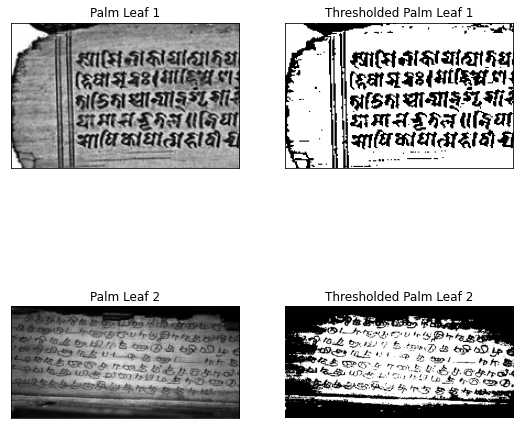

In [6]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9,9))
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])

ax1.imshow(palm_leaf_1, 'gray')
ax1.title.set_text('Palm Leaf 1')
ax2.imshow(binary_palm_leaf_1, 'gray')
ax2.title.set_text('Thresholded Palm Leaf 1')
ax3.imshow(palm_leaf_2, 'gray')
ax3.title.set_text('Palm Leaf 2')
ax4.imshow(binary_palm_leaf_2, 'gray')
ax4.title.set_text('Thresholded Palm Leaf 2')

plt.axis('off')
plt.show()   

## K means clusering
We take the number of clusters to be 3. The pixels in the image are randomly labelled one of the K values. The mean of the clusters is computed and the cluster centroids are designated. We then compute the distance of the image pixels from the centroids and reassign labels to get the new clusters and recompute the cluster centroid. This is recursively implemented till a tolerance level is reached.

We look to observe the effect of randomized initialization vs given initialization.

In [7]:
def k_means_classifier(image, centroids=None, K=3, max_iter=5, n_inits=30,
                       low=0, high=255, tolerance=1e-12, return_centroids=False):
    x, y, z = np.shape(image)
    data = np.zeros((x*y, 3))
    for i in range(3):
        data[:, i] = np.ravel(image[:, :, i])
    n_samples, n_features = np.shape(data)
    # randomly initialize labels
    labels = np.random.randint(low=0, high=K, size=n_samples)
    # compute distances
    distances = np.zeros((K, n_samples))
    # when cluster centres are initialised
    if centroids is not None:
        for i in range(max_iter):
            for k in range(K):
                c = centroids[k]
                # get the distance of each point from a centroid
                distances[k] = np.sum((data - c)**2, axis=1)
            # get new labels based on distances to centroids calculated
            new_labels = np.argmin(distances, axis=0)
            # check for convergence
            if (np.mean(np.abs(labels-new_labels)) <= tolerance):
                # if convergence has taken place, assign labels and exit
                labels = new_labels
                break
            else:
                # else update labels
                labels = new_labels
                for c in range(K):
                    # update centroids
                    centroids[c] = np.mean(data[labels == c], axis=0)
    # when initial cluster centers are not provided
    else:
        # initialize variables
        best_cost = np.inf
        centroids = np.zeros((K, n_features))
        best_labels = labels.copy()
        for n in range(n_inits):
            # for each run of k-means, randomly initiate centers
            init = np.random.uniform(0, 255, size=(K, n_features))
            for i in range(max_iter):
                for k in range(K):
                    c = init[k]
                    distances[k] = np.sum((data - c)**2, axis=1)
                new_labels = np.argmin(distances, axis=0)
                if (np.min(np.abs(labels-new_labels)) <= tolerance):
                    labels = new_labels
                    break
                else:
                    labels = new_labels
                    avaliable_labels = set(labels)
                    for c in range(K):
                        # if a cluster has points, update the corresponding centroid
                        if c in avaliable_labels:
                            init[c] = np.mean(data[labels == c], axis=0)
                        else:
                            init[c] = np.random.uniform(0, 255, n_features)
            # get the cost as the sum of the minimum distance of each point from some cluster center
            cost = np.sum(np.min(distances), axis=0)
            # update the cost, centroids and labels when you get a lower cost
            if cost < best_cost:
                best_cost = cost
                centroids = init
                best_labels = labels
        labels = best_labels
    # return centroids only if asked for
    if not return_centroids:
        return labels
    else:
        return labels, centroids

In [8]:
def segment_rgb_image(image, centroids_=None, K=3, max_iter=5, n_inits=30,
                      tolerance=1e-12, set_centroids=False):
    x, y, z = np.shape(image)
    data = np.zeros((x*y, 3))
    for i in range(3):
        data[:, i] = np.ravel(image[:, :, i])
    flattened_image = data
    final_image = np.zeros_like(flattened_image)
    labels, centroids = k_means_classifier(image=image, centroids=centroids_, K = K, 
                                           max_iter=max_iter, n_inits=n_inits,
                                           tolerance=tolerance, return_centroids=True)
    # get the labels present
    all_labels = set(labels)
    for label in all_labels:
        if not set_centroids:
            # in this case, to all pixels with label k, assign their average color
            final_image[labels == label] = np.mean(
                flattened_image[labels == label], axis=0)
        else:
            # in this case, to all pixels with label k, assign the kth centroid. The 
            # previous one often gives better results
            final_image[labels == label] = centroids[label]
    final_image = final_image/255
    return final_image.reshape(x, y, 3)

In [9]:
c_init = np.zeros((3, 3))
c_init[0, 0] = 255
c_init[2] = 255
car_segmented_given_init = segment_rgb_image(car, centroids_=c_init, max_iter=5)
flower_segmented_given_init = segment_rgb_image(flower, centroids_=c_init, max_iter=5)

## Visualise Image clustering

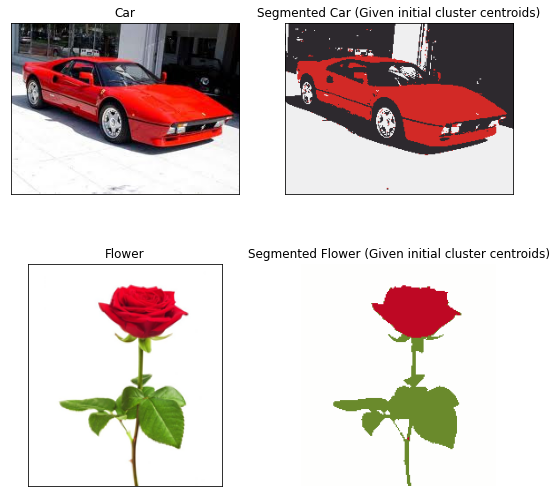

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9,9))
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])

ax1.imshow(car, 'gray')
ax1.title.set_text('Car')
ax2.imshow(car_segmented_given_init, 'gray')
ax2.title.set_text('Segmented Car (Given initial cluster centroids)')
ax3.imshow(flower, 'gray')
ax3.title.set_text('Flower')
ax4.imshow(flower_segmented_given_init, 'gray')
ax4.title.set_text('Segmented Flower (Given initial cluster centroids)')

plt.axis('off')
plt.show()   

In [13]:
car_segmented_random = segment_rgb_image(car, centroids_=None, max_iter=5)
flower_segmented_random = segment_rgb_image(flower, centroids_=None, max_iter=5)

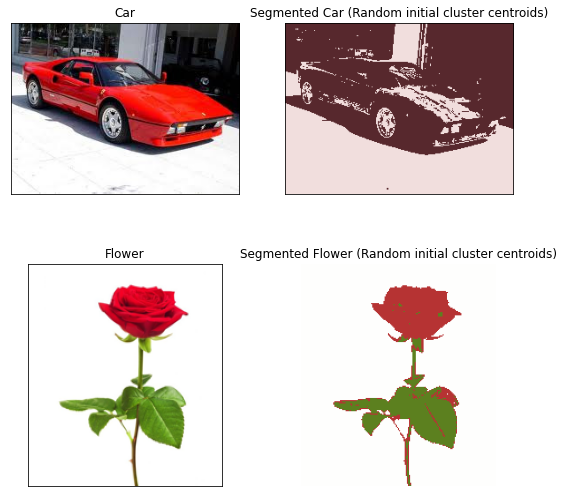

In [14]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9,9))
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])

ax1.imshow(car, 'gray')
ax1.title.set_text('Car')
ax2.imshow(car_segmented_random, 'gray')
ax2.title.set_text('Segmented Car (Random initial cluster centroids)')
ax3.imshow(flower, 'gray')
ax3.title.set_text('Flower')
ax4.imshow(flower_segmented_random, 'gray')
ax4.title.set_text('Segmented Flower (Random initial cluster centroids)')

plt.axis('off')
plt.show()   

## Observations
1. The binarizing of an image using Otsu thresholding uses global threshold. Palm leaf 1 has a somewhat uniform illumination. The binarizing is good. However, the Palm leaf 2 is poor however due to the poor illumination along the borders. Local thresholding methods will better perform in this case.
2. We observe to be true that the K-means clustering algorithm is  greedy and converges to a local minimum. Thus, when random initialization is done, we see K-means clustering underperforming.